In [3]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import csv
from scipy.optimize import curve_fit


Populating the interactive namespace from numpy and matplotlib


0 0 217.45186578142307 0.04598718876963667 0.4773053005465703
0 1 226.8981422031011 0.04407263939185892 0.5271049003185138
0 2 222.78957843955118 0.044885402944075635 0.5070803152256783
0 3 229.13246235812858 0.0436428775612346 0.5577166488904057
0 4 230.63258779958005 0.04335900704843155 0.6151865318968616
0 5 229.13820378872424 0.043641784017912834 0.5379433332687696
0 6 212.300319435358 0.04710308503819674 0.6106615992110709
0 7 227.22529616540714 0.04400918457917012 0.5810599556240748
0 8 224.68496950071062 0.04450675994136035 0.6346252155370361
0 9 224.99648117549532 0.044445139531760436 0.5946114206214907
0 10 223.65165993429173 0.04471238891291025 0.5343356452874409
0 11 228.37933703171188 0.0437867984467064 0.649763119960462
0 12 222.8421254904133 0.044874818789278695 0.6904212400027966
0 13 222.37757714626719 0.04496856260567393 0.6212467585411819
0 14 226.5339595828152 0.04414349185621438 0.5190627170885405
0 15 221.99059112785494 0.045046954238887195 0.5288649290557537
1 0 4

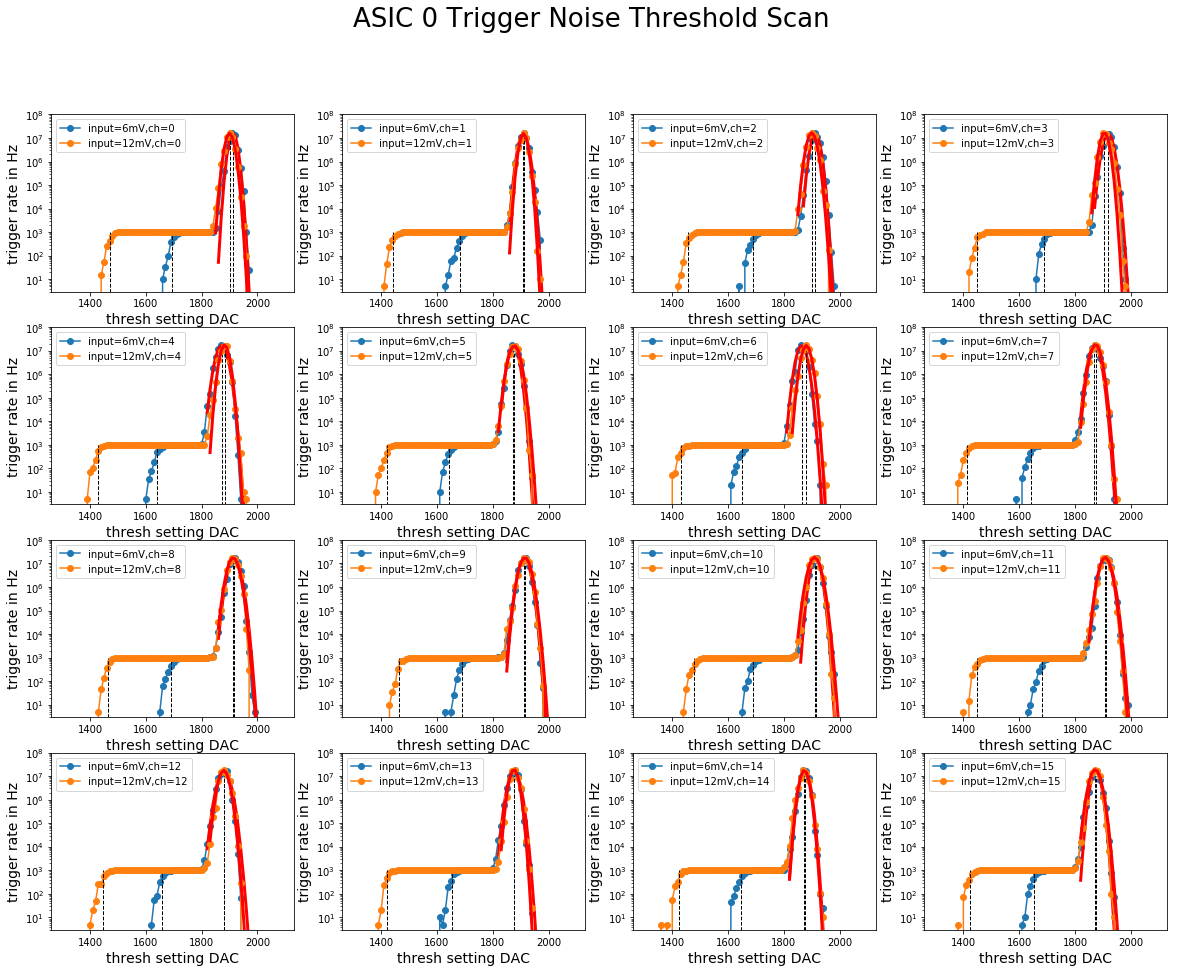

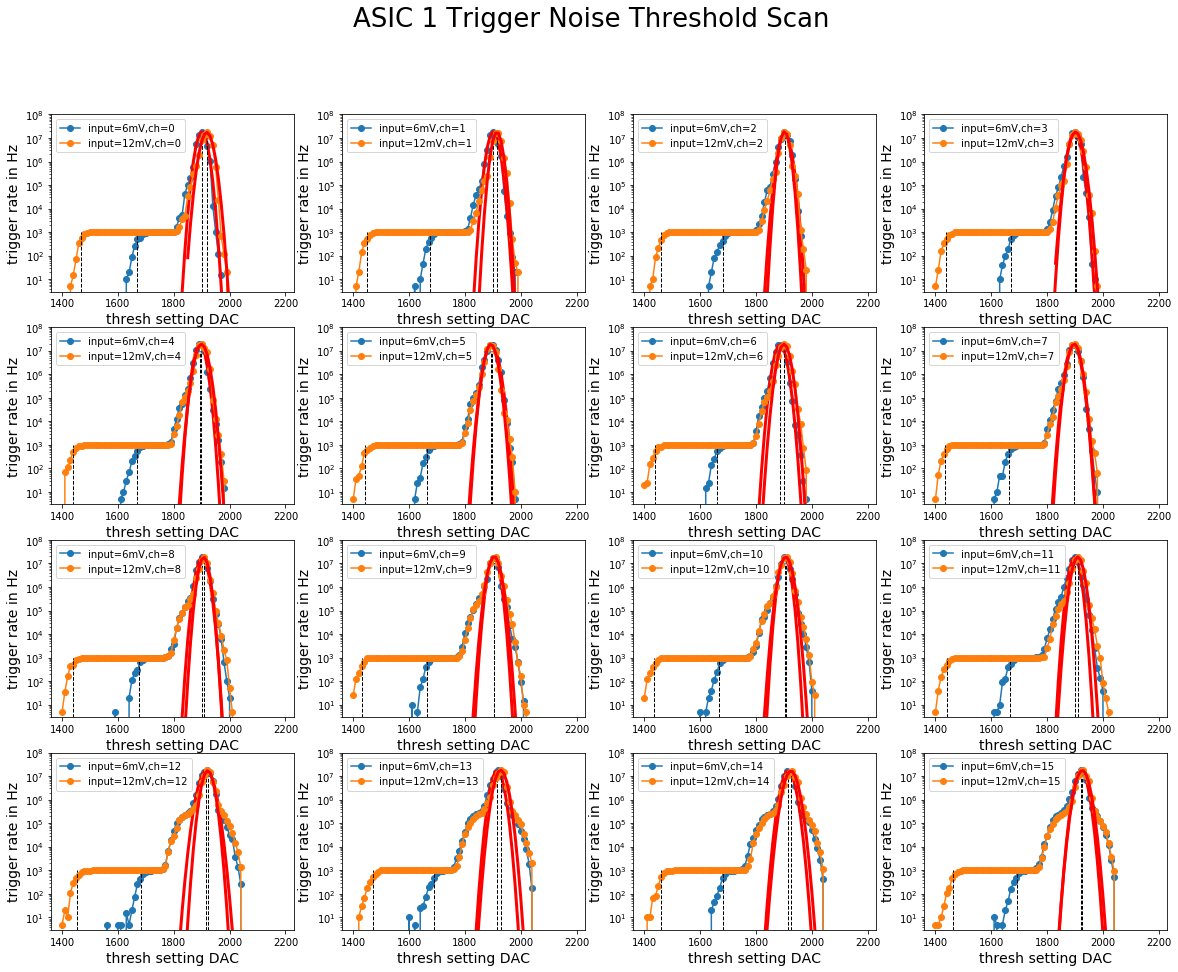

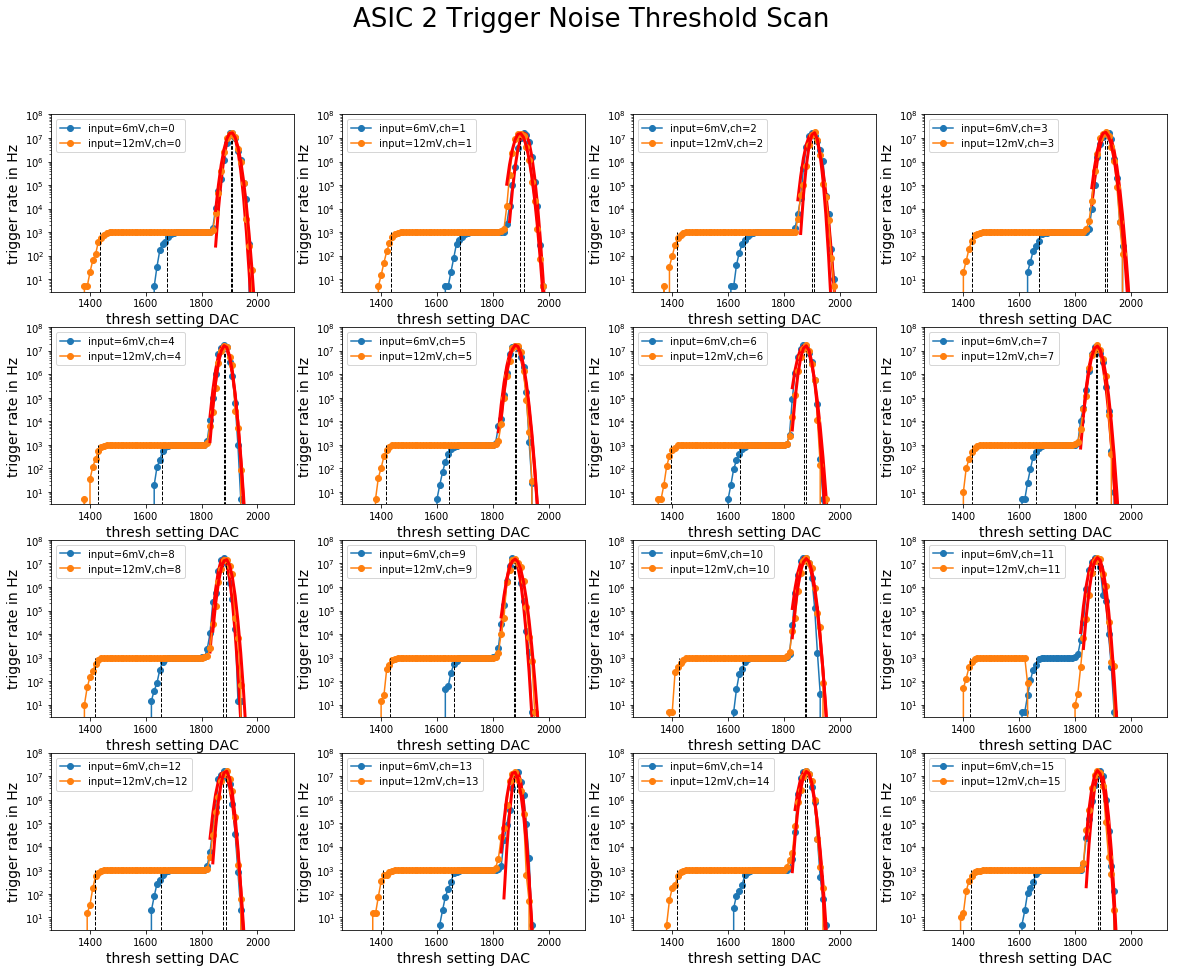

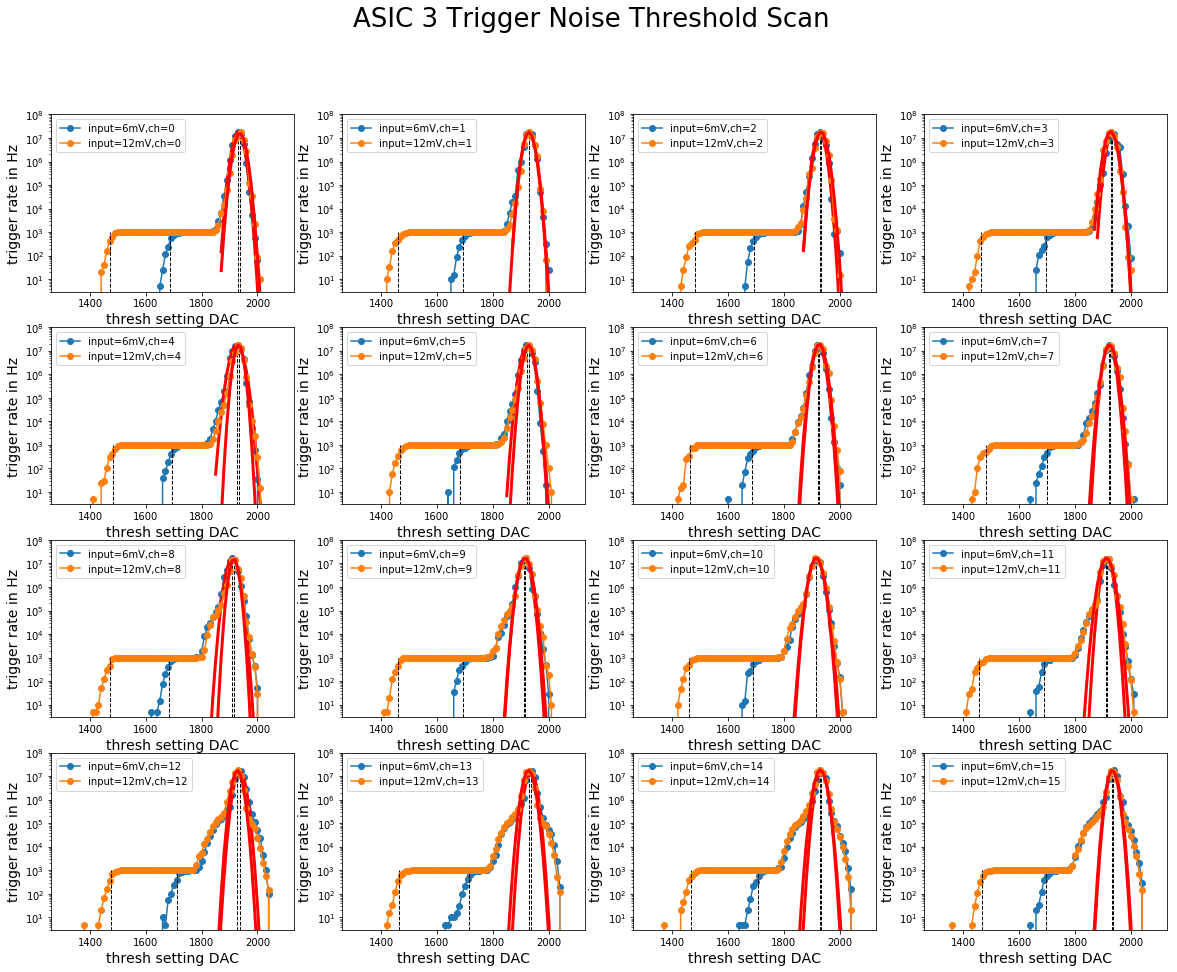

In [6]:
asics = [0, 1, 2, 3]
directory = "/data/wipac/CTA/target5and7data/testData2019/module3/T5TEATesting/"
#read data for trig ena scans checks:
timestamps = ["20190916_1825/", "20190916_1646/", "20190917_0929/", "20190916_1701/"]

def gauss(x, sigma, mu, a):
    return a/sqrt(2.0*np.pi*sigma**2)*exp( -(x - mu)**2/( 2.0*sigma**2 )  )

def find50(dataX, dataY):
    #finalX = 1500
    for i in range(dataY.shape[0]-1):
        if(dataY[i]<100.0 and dataY[i+1]>=100.0):
            x1 = dataX[i]
            x2 = dataX[i+1]
            y1 = dataY[i]
            y2 = dataY[i+1]
            m = (y2-y1)/(x2-x1)
            finalX = (100.0 - y1)/m + x1
            break
    #print finalX
    return finalX

def findPeak(dataY):
    for i in range(dataY.shape[0]):
        if(dataY[i]>1000.0):
            return i

for asic in asics:
    trigEnaList=[0,1]
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,15))
    amplitude = np.zeros((2,16))
    realAmplitude = np.zeros((2,16))
    noise = []

    homedir = os.environ['HOME']

    #filename = open("{}/Desktop/Grad School/Research/fit_parameters_trigger_noise_asic{}.txt".format(homedir, asic), 'w')
    filename = open(directory + "fit_parameters_trigger_noise_asic_{}.txt".format(asic), 'w')
    writer = csv.writer(filename, delimiter=',')
    writer.writerow(['Set', 'Channel', 'CountsPerAmplmV', 'Calibration', 'CalibratedSigma'])
    #noise = np.zeros((2,16))
    for g in range(2):
        allData=[]

        for i in range(16):
            ampl = 20 + 20 * g
            data = loadtxt(directory + timestamps[asic] + "threshScan_ampl_"+str(ampl)+"_g_"+str(asic*4+i/4)+"_ch_"+str(i)+".dat")

            allData.append(data)
            lala = (g + 1) * 6
            la = "input="+str(lala)+"mV,ch="+str(i)

            amplitude[g,i] = find50(allData[i][:,0],allData[i][:,1])
            realAmplitude[g,i] = ampl/2.0
            start = findPeak(allData[i][:,1])
            top = allData[i][argmax(allData[i][:,1]),0]

            popt, pocv = curve_fit(gauss, allData[i][start:,0],allData[i][start:,1], p0=[50,top,1e7])
            #print top, popt

            cal = realAmplitude[g,i]/abs(popt[1] - amplitude[g,i])
            noise.append( cal*abs(popt[0]) )
            print g, i, popt[1] - amplitude[g,i], cal, cal*abs(popt[0])
            writer.writerow([g, i, popt[1] - amplitude[g,i], cal, cal*abs(popt[0])])

            ax[i/4,(i%4)].plot(allData[i][:,0],allData[i][:,1]/0.2, label=la, marker = 'o')
            ax[i/4,(i%4)].plot(allData[i][start:,0],gauss(allData[i][start:,0], popt[0], popt[1], popt[2])/0.2, linewidth=3, color='r')
            ax[i/4,(i%4)].plot([amplitude[g,i], amplitude[g,i]], [1,1000], color='black', linewidth=1, linestyle='--')
            ax[i/4,(i%4)].plot([popt[1], popt[1]], [1,1e7], color='black', linewidth=1, linestyle='--')
            ax[i/4,(i%4)].legend(loc='upper left')
            ax[i/4,(i%4)].set_yscale('log')
            ax[i/4,(i%4)].set_xlabel('thresh setting DAC', fontsize=14)
            ax[i/4,(i%4)].set_ylabel('trigger rate in Hz', fontsize=14)
            ax[i/4,(i%4)].set_ylim(3,1e8)

    filename.close()
    fig.suptitle("ASIC {} Trigger Noise Threshold Scan".format(asic), fontsize=26)
    fig.savefig(directory + "figures/trigger_noise_asic_{}_ampl_6_12_mV_10_ns.pdf".format(asic))
    fig.show()

Done with ASIC 0
Done with ASIC 1
Done with ASIC 2
Done with ASIC 3


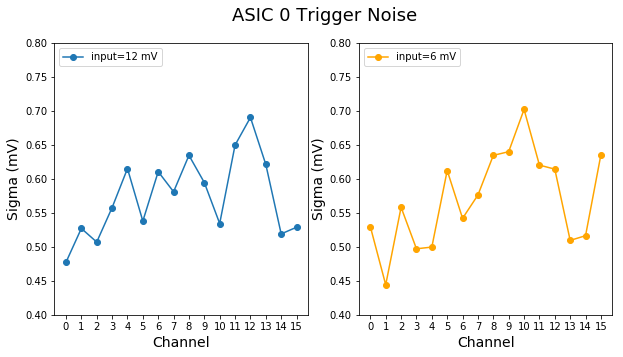

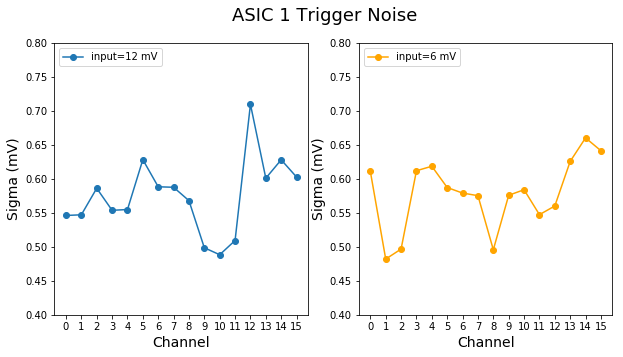

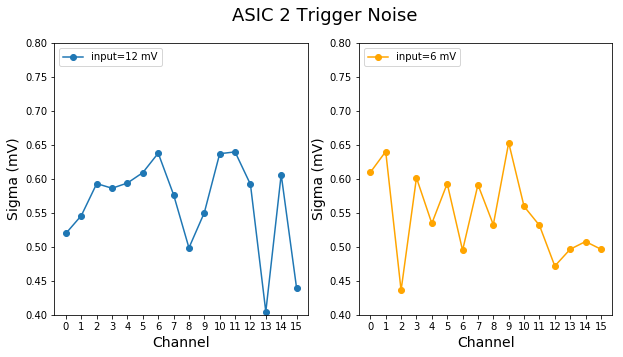

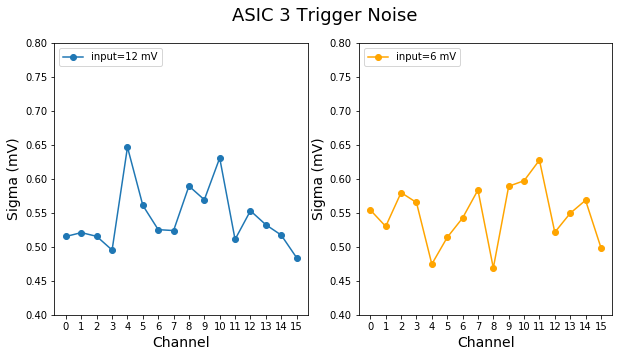

In [8]:
for asic in asics:
    datafile = directory + "fit_parameters_trigger_noise_asic_{}.txt".format(asic)
    results = np.loadtxt(datafile, delimiter=',', skiprows=1)
    #print(results)
    results = results.T

    hi_channel, low_channel = [results[1][results[0] == n] for n in [0., 1.]]
    hi_calsig, low_calsig = [results[4][results[0] == n] for n in [0., 1.]]

    #print(hi_calsig)
    #print(low_calsig)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    hi_la = "input=12 mV"
    xticks = np.linspace(0, 16, 16, endpoint=False)
    #print(xticks)
    ax[0].plot(hi_channel, hi_calsig, label=hi_la, marker='o')
    ax[0].legend(loc='upper left')
    ax[0].set_ylabel('Sigma (mV)', fontsize=14)
    ax[0].set_xticks(xticks)
    ax[0].set_xlabel('Channel', fontsize=14)
    ax[0].set_ylim(0.4, 0.8)

    low_la = "input=6 mV"
    ax[1].plot(low_channel, low_calsig, label=low_la, marker='o', color='orange')
    ax[1].legend(loc='upper left')
    ax[1].set_ylabel('Sigma (mV)', fontsize=14)
    ax[1].set_xlabel('Channel', fontsize=14)
    ax[1].set_xticks(xticks)
    ax[1].set_ylim(0.4, 0.8)

    fig.suptitle('ASIC {} Trigger Noise'.format(asic), fontsize=18)
    fig.savefig(directory + 'figures/trigger_noise_asic{}_sigmas.pdf'.format(asic))
    fig.show()
    print("Done with ASIC {}".format(asic))
